In your project, you will pick a dataset (time-series) and an associated problem that can be
solved via sequence models. You must describe why you need sequence models to solve this
problem. Include a link to the dataset source. Next, you should pick an RNN framework that you
would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other
Python Package). 

I used the famous Shakespeare's plays dataset containing Shakespeare's works (https://www.kaggle.com/datasets/kingburrito666/shakespeare-plays?resource=download, only the txt file). Only sequence models would work on this dataset as its text and it requires positional awareness to predict the next token.

In [36]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM, GRU
from tensorflow.keras import Sequential
from typing import List
import matplotlib.pyplot as plt

In [45]:
# upon inspecting the data it is evident that there are many kinds of punctuation
# we would like a word like "hi!"" to equal tokens of "hi" + "!" rather
# than having "hi" "hi!" be completely different tokens
# such is the case for all other punctuation
# one punctuating character that appears specific to these works 
# is "--" which has been added to the special punctuation characters 


# returns to_add_tokens, word without punctuation
punctuation = [",", ".", "!", ":", ";", ")", "]", "--", "(", "["]
def account_for_punct(word):
    to_add_tokens = []
    # check for (, only character that occurs at the beginning
    # others will be at the end

    # if these are the only characters do not check for suffix punctuation
    if word == "[" or word == "(":
        return [punctuation.index(word) + 2], ""

    if "(" == word[0] or "[" == word[0]:
        to_add_tokens.append(punctuation.index("(") + 2)
        word = word[1:]


    # check for end of character punctuation
    end_char = word[-1]
    if end_char in punctuation:
        to_add_tokens.append(punctuation.index(end_char) + 2)
        word = word[:-1]

    return to_add_tokens, word

    

# takes in raw text as array of strings
def get_token_mappings(inpt: List[str]):
    counter = 2 + len(punctuation) # reserved for punctuation
    str_to_token = {"\n" : 0, "": 1} 
    token_to_str = {0: "\n", 1: ""}

    # add the punctuation in
    for i, punct in enumerate(punctuation):
        token_to_str[i + 2] = punct
        str_to_token[punct] = i + 2

    # go line by line and add newline char to end of token input
    tokenized = []
    for line in inpt:
        # remove " character
        line = line.replace('"', "").replace("\n", "").lower()
        # word based tokenization
        words = line.split(" ")

        for word in words:
            # skip token
            if word == "":
                tokenized.append(1)
                continue

            # process punctuation, gets added before word
            # likely not the best strategy but should suffice
            # for this use case
            to_add_tokens, word = account_for_punct(word)
            for token in to_add_tokens:
                tokenized.append(token)

            # add word if not in vocab
            if word not in str_to_token:
                str_to_token[word] = counter
                token_to_str[counter] = word
                counter += 1

            # tokenize processed word
            tokenized.append(str_to_token[word])

        # add newline token
        tokenized.append(0)

    # convert to np array 
    tokenized = np.array(tokenized).reshape(len(tokenized), 1)
    return str_to_token, token_to_str, counter, tokenized

def tokenize(str_to_token, string):
    tokenized = []
    for line in string.split("\n"):
        line = line.replace('"', "").replace("\n", "").lower()
        words = line.split(" ")
        for word in words:
            if word == "":
                tokenized.append(1)
                continue

            to_add_tokens, word = account_for_punct(word)
            for token in to_add_tokens:
                tokenized.append(token)

            tokenized.append(str_to_token[word])

        tokenized.append(0)

    return np.array(tokenized).reshape(len(tokenized), 1)


def lookup(token_to_str, tokens):
    if type(tokens) == np.ndarray:
        tokens = tokens.flatten()

    string = []

    prev_punct = None

    for token in tokens:
        if token == 0:
            string.append("\n")
        elif token == 1:
            string.append("")
        elif token < 2 + len(punctuation):
            punct = punctuation[token - 2]
            if not prev_punct:
                prev_punct = punct
            else:
                if type(prev_punct) == list:
                    prev_punct = prev_punct[0]
                    
                prev_punct = [prev_punct, punct]
        else:
            word = token_to_str[token]
            if prev_punct:
                if type(prev_punct) == list:
                    word = prev_punct[0] + word + prev_punct[1]
                elif prev_punct == "[" or prev_punct == "(":
                    word = prev_punct + word
                else:
                    word = word + prev_punct

                prev_punct = None
            string.append(word)

    return " ".join(string)
            

with open("alllines.txt") as file:
    data = file.readlines()
data = data[:10000]

str_to_token, token_to_str, n_tokens, tokenized = get_token_mappings(data)
print(f"number of unique tokens: {n_tokens}")
random_line_number = int(np.random.rand() * len(data))
random_line = data[random_line_number].replace('"', "").replace("\n", "").lower()
print(f"random line of data: '{random_line}'")
print(f"tokenized version: {tokenize(str_to_token, random_line)}")
reconstructed = lookup(token_to_str, tokenize(str_to_token, random_line)).replace("\n", "")
print(f"reconstructed version from tokens: '{reconstructed}'")

number of unique tokens: 8643
random line of data: 'see riot and dishonour stain the brow'
tokenized version: [322, 369, 30, 370, 371, 16, 372, 0]
reconstructed version from tokens: 'see riot and dishonour stain the brow '


In [22]:
def one_hot_encode_tokens(token_data, n_tokens):
    output = np.zeros((len(token_data), n_tokens))
    for i, token in enumerate(token_data):
        output[i][token] = 1

    return output

def reverse_one_hot_encode(one_hot_encoded):
    tokens = []
    for one_hot in one_hot_encoded:
        tokens.append(np.argmax(one_hot))
    return tokens

In [83]:
split = 0.8
split_index = int(len(tokenized) * split)
data_train = tokenized[:split_index]
data_test = tokenized[split_index:]

data_train = data_train[:-1], one_hot_encode_tokens(data_train[1:], n_tokens) # y is shifted 1 over
data_test = data_test[:-1], one_hot_encode_tokens(data_test[1:], n_tokens)

## Task 1 (60 points):

### Part 1 (30 points): 
Implement your RNN either using an existing framework OR you can
implement your own RNN cell structure. In either case, describe the structure of your
RNN and the activation functions you are using for each time step and in the output
layer. Define a metric you will use to measure the performance of your model (NOTE:
Performance should be measured both for the validation set and the test set).

In [84]:
units = [64, 64, 128, 512]

model = Sequential([
    Embedding(n_tokens, input_length=1, output_dim=units[0]),
    SimpleRNN(units[1], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    SimpleRNN(units[2], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    SimpleRNN(units[3], activation="relu", kernel_initializer="he_uniform"),
    Dense(n_tokens, activation="softmax", kernel_initializer="glorot_uniform")
])

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1, 64)             553152    
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 1, 64)             8256      
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 1, 128)            24704     
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 512)               328192    
                                                                 
 dense_8 (Dense)             (None, 8643)              4433859   
                                                                 
Total params: 5,348,163
Trainable params: 5,348,163
Non-trainable params: 0
_________________________________________________________________


In [88]:
history = model.fit(*data_train, validation_data=data_test, epochs=2)

Epoch 1/2
2494/2494 [==============================] - 105s 42ms/step - loss: 5.8809 - val_loss: 5.7368
Epoch 2/2
2494/2494 [==============================] - 85s 34ms/step - loss: 5.3172 - val_loss: 5.7641


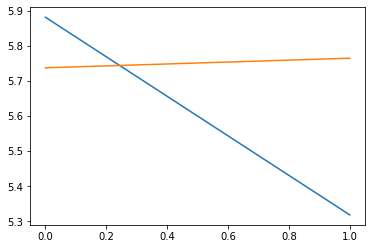

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [90]:
one_hot_pred = model(data_train[0][300:400])
tokens = reverse_one_hot_encode(one_hot_pred)
print("text input:", lookup(token_to_str, data_train[0][300:400].flatten()), "\n\npredicted for each word:")
lookup(token_to_str, tokens)

text input: and bootless 'tis to tell you we will go: 
 therefore we meet not now. then let me hear 
 of you, my gentle cousin westmoreland, 
 what yesternight our council did decree 
 in forwarding this dear expedience. 
 my liege, this haste was hot in question, 
 and many limits of the charge set down 
 but yesternight: when all athwart there came 
 a post from wales loaden with heavy news, 
 whose worst was, that the noble mortimer, 
 leading the men of herefordshire to 

predicted for each word:


',the, ,be, me \n \n ,me, \n me, \n \n ,lord, \n ,lord, \n \n \n \n ,the, \n ,me, \n ,lord, \n \n ,the, lord \n \n \n \n \n ,me, \n i \n \n is \n \n ,the, \n \n the lord, \n ,lord, ,lord, \n \n \n \n ,the,'

### Part 2 (35 points): 
Update your network from part 1 with first an LSTM and then a GRU
based cell structure (You can treat both as 2 separate implementations). Re-do the
training and performance evaluation. What are the major differences you notice? Why
do you think those differences exist between the 3 implementations (basic RNN, LSTM
and GRU)?
Note: In part 1 and 2, you must perform sufficient data-visualization, pre-processing
and/or feature-engineering if needed. The overall performance visualization of the loss
function should also be provided.


#### LSTM

In [64]:
units = [64, 64, 128, 512]

model = Sequential([
    Embedding(n_tokens, output_dim=units[0]),
    LSTM(units[1], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    LSTM(units[2], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    LSTM(units[3], activation="relu", kernel_initializer="he_uniform"),
    Dense(n_tokens, activation="softmax", kernel_initializer="glorot_uniform")
])

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          553152    
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         98816     
                                                                 
 lstm_2 (LSTM)               (None, 512)               1312768   
                                                                 
 dense_6 (Dense)             (None, 8643)              4433859   
                                                                 
Total params: 6,431,619
Trainable params: 6,431,619
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(*data_train, validation_data=data_test, epochs=2)

3118/3118 [==============================] - 151s 47ms/step - loss: 6.0431


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
one_hot_pred = model(data_train[0][300:400])
tokens = reverse_one_hot_encode(one_hot_pred)
print("text input:", lookup(token_to_str, data_train[0][300:400].flatten()), "\n\npredicted for each word:")
lookup(token_to_str, tokens)

#### GRU

In [67]:
units = [64, 64, 128, 512]

model = Sequential([
    Embedding(n_tokens, output_dim=units[0]),
    GRU(units[1], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    GRU(units[2], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    GRU(units[3], activation="relu", kernel_initializer="he_uniform"),
    Dense(n_tokens, activation="softmax", kernel_initializer="glorot_uniform")
])

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          553152    
                                                                 
 gru (GRU)                   (None, None, 64)          24960     
                                                                 
 gru_1 (GRU)                 (None, None, 128)         74496     
                                                                 
 gru_2 (GRU)                 (None, 512)               986112    
                                                                 
 dense_7 (Dense)             (None, 8643)              4433859   
                                                                 
Total params: 6,072,579
Trainable params: 6,072,579
Non-trainable params: 0
_________________________________________________________________


In [68]:
history = model.fit(*data_train, validation_data=data_test, epochs=2)

3118/3118 [==============================] - 133s 42ms/step - loss: 5.9439


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
one_hot_pred = model(data_train[0][300:400])
tokens = reverse_one_hot_encode(one_hot_pred)
print("text input:", lookup(token_to_str, data_train[0][300:400].flatten()), "\n\npredicted for each word:")
lookup(token_to_str, tokens)

### Part 3 (10 points): 
Can you use the traditional feed-forward network to solve the same
problem. Why or why not? (Hint: Can time series data be converted to usual features
that can be used as input to a feed-forward network?)

It would not be a complete solution but it would be possible to pass a window of the input, however, this would be memory intensive and would still not capture the full context of the input as any context outside of the window is lost to the model.

## Task 2 (25 points):

In this task, use any of the pre-trained word embeddings. The Wor2vec embedding link
provided with the lecture notes can be useful to get started. Write your own code/function that 
uses these embeddings and outputs cosine similarity and a dissimilarity score for any 2 pair of
words (read as user input). The dissimilarity score should be defined by you. You either can
have your own idea of a dissimilarity score or refer to literature (cite the paper you used). In
either case clearly describe how this score helps determine the dissimilarity between 2 words.

Note: Dissimilarity measure has been an important metric for recommender systems trying to
introduce ‘Novelty and Diversity’ in assortments (as opposed to only accuracy). You might find
different metrics of dissimilarity in recommender system’s literature.

In [92]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

corpus = api.load('text8')
model = Word2Vec(corpus)

def cosine_sim(a, b):
    return a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

# similarity and distance metrics are inverses of each other
# this is usually a multiplicative relationship
# ie. cosine distance would be 1 / cosine similarity
# therefore distances are the same as dissimilarity
# one very general distance metric is the minkowski distance
# this is a generalization of the euclidian, manhattan 
# and chebyshev distances
# p = 1,   manhattan
# p = 2,   euclidian
# p = inf, chebyshev
def minkowski(a, b, p):
    return np.power(np.sum(np.power(np.linalg.norm(a - b),p)), 1/p)

ValueError: unable to read local cache '/Users/danielkopp/gensim-data/information.json' during fallback, connect to the Internet and retry

In [ ]:
word1 = input("enter the first word: ")
print(f"the first word is '{word1}'")

word2 = input("enter the second word: ")
print(f"the first word is '{word2}'")

vec1, vec2 = model[word1], model[word2]

print(f"cosine similarity = {cosine_sim(vec1, vec2)}")
print(f"manhattan distance = {minkowski(vec1, vec2, 1)}")
print(f"euclidan distance = {minkowski(vec1, vec2, 2)}")
print(f"chebychev distance = {minkowski(vec1, vec2, np.inf)}")